In [1]:
import numpy as np
import random
import sympy as sp
import numpy.linalg as la

import control as pc

%matplotlib notebook
import matplotlib.pyplot as plt
plt.ioff()

from sysident import iekf_SISO
plt.rcParams['figure.figsize'] = [10, 5]

In [2]:
# Sampling time
# SET_PARAMETER
iekf_fqz = 125
iekf_T = 1.0/iekf_fqz

# Modellabtastung
T = 1.0/1000
T_max = 0.5*60 #

# noiselevel
scale = 0.1

In [3]:
''' Define Idetification System model with initial values
System is characterized by number of poles given with numerical values
'''

poles = [-2+3j, -2]
_, (s, s_init), (w, w_init), (p, p_init) = iekf_SISO.getA_from_list(poles)

iekf = iekf_SISO.iekf_filter(poles, dT=iekf_T, rho = 0.5)

iekf.initialize_poles(s_init, w_init, p_init)

Starting IEKF with model stucture assumption (System matrix modal form)
A:
⎡s₁   w₁  0 ⎤
⎢           ⎥
⎢-w₁  s₁  0 ⎥
⎢           ⎥
⎣ 0   0   p₁⎦


In [4]:
# first step height u, also mean step height for all steps
u_k0 = np.array([[0.1]])

# first step time
step_time = 0.1

# First values
#x_k = x_k0
#print x_k0, x_k0.shape

u_k = u_k0
#print u_k, u_k.shape

# naive Logging x_k
poles = []
zeros = []
y = []
y_e = []
t_ye = []

u = []
nor0 = []
nor1 = []
nor2 = []
nor3 = []
nor4 = []

step_cnt = 1


In [5]:
import control as con

Af = np.array([[  0.,         -11.06378158],
               [100.,         -74.7335531 ]]
)

Bf = np.array([[-11.11006912],
               [  0.        ]])

Cf = np.array([[ 0., -1.]])

Df = np.array([[ 0.]])

Tf = 0.03306113

pade_order = 3

ss2 = con.ss(Af, Bf, Cf, Df)
#plt.plot(*con.step_response(ss2))
#plt.show()

print con.dcgain(ss2)
print ss2.pole()

# pade approx
numerator, denominator = con.pade(Tf, pade_order)

tf3 = con.series(ss2, con.tf(numerator,denominator))
ss3 = con.tf2ss(tf3)

#plt.plot(*con.step_response(ss3))
#plt.show()

Af = ss3.A
Bf = ss3.B
Cf = ss3.C
Df = ss3.D

print ss3

### Testsystem ####
xx_0 = np.zeros((len(Bf),1))

x_t_real = xx_0
def calc_TestSystem(u):
    global Af, Bf, Cf, Df, x_t_real

    #print "Af:\n", Af
    #print "x_t:\n", x_t_real
    x_dot = Af.dot(x_t_real)
    x_dot = x_dot + Bf.dot(u)
    y = Cf.dot(x_t_real) + Df.dot(u)
    
    #print x_dot
    x_t_real = x_t_real + x_dot*T

    y =  y + np.random.normal(0, scale)
    return y

[[1.0041837]]
[-54.39316289 -20.34039021]
A = [[-9.94759830e-14  7.33817988e-14  6.60095341e-14  4.57602705e-14
   3.67393746e+00]
 [ 1.00000000e+02  5.61019710e-14  4.33963367e-14 -5.47567951e-14
   3.08899128e+01]
 [ 0.00000000e+00 -1.00000000e+02  7.18998157e-14 -1.71533536e-13
  -7.82460267e+01]
 [ 0.00000000e+00  0.00000000e+00 -1.00000000e+02 -3.14481925e-14
   8.31248282e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e+03
  -4.37697553e+02]]

B = [[ 36.89308114]
 [-60.98634759]
 [-40.32555132]
 [-11.11006912]
 [  0.        ]]

C = [[ 0.   0.   0.   0.  -0.1]]

D = [[0.]]



In [6]:
# return real part of a vector
def real_vector(vector):
    return map(lambda x: x.real, vector)

# return imaginary part of a vector
def imag_vector(vector):
    return map(lambda x: x.imag, vector)

In [7]:
%%time
##########################################################
# Loop start
for cnt, t in enumerate(np.arange(T, T_max, T)):

    ####################################################
    # Every time_step a new step is performed
    if np.isclose(t, step_time, T):
        u_k = u_k0 + random.uniform(-1, 1) # random step height
        
        step = np.random.randint(low=0, high=3000)*T
        step_time = step + t # random step length

        #print "step @ {} for {}: u={}".format(t, step, u_k)
        
        # >>> Logging of pole trajectories
        s_k = np.array(iekf.s_from_z(*iekf.z_k.ravel())).T
        w_k = np.array(iekf.w_from_z(*iekf.z_k.ravel())).T
        p_k = np.array(iekf.p_from_z(*iekf.z_k.ravel())).T
        poles.append(np.array([complex(si,wi) for si,wi in zip(s_k, w_k)] +
                              [complex(si,-wi) for si,wi in zip(s_k, w_k)] +
                              [pi for pi in p_k]))

        A_k = iekf.AA(*iekf.z_k.ravel())
        B_k = iekf.BB(*iekf.z_k.ravel())
        C_k = iekf.C0
        D_k = iekf.DD(*iekf.z_k.ravel())
        zeros.append(pc.zero(pc.ss(A_k, B_k, C_k, D_k)))
        
        
        step_cnt = step_cnt + 1
        #print u_k, type(u_k), u_k.shape
        
    # >>> Logging of u
    u.append(u_k[0,0])
    
    ####################################################
    
    ##### Get system response y
    y_t = calc_TestSystem(u_k)
    #print u_k, u_k.shape
    #print y_t, y_t.shape
    
    # >>> Logging of y
    y.append(y_t[0,0])
    
    # Works only for integer divisions of frequencies!
    if cnt%int(iekf_T/T) == 0:
        t_ye.append(t)
        
        y_k, err = iekf.callback_u(u_k[0,0], y_t[0,0])
        

        # >>> Logging of estimated y (y_e) according to current state z
        y_e.append(y_k[0,0])


        # Naive tracking of performance 
        nor0.append(np.trace(iekf.P_k))
        nor1.append(la.norm(iekf.P_k, 'fro'))
        nor2.append(la.norm(iekf.P_k, np.inf))
        nor3.append(la.norm(iekf.P_k, 1))
        nor4.append(la.norm(iekf.P_k, 2))
    
print "------------------"

------------------
CPU times: user 2.54 s, sys: 0 ns, total: 2.54 s
Wall time: 2.54 s


In [8]:
def add_arrow(line, position=None, direction='right', size=15, color=None):
    """
    add an arrow to a line.

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if position is None:
        position = xdata.mean()
    # find closest index
    start_ind = np.argmin(np.absolute(xdata - position))
    #start_ind = len(xdata) // 2
    #start_ind = len(xdata) * 1/3
    if direction == 'right':
        end_ind = start_ind + 1
    else:
        end_ind = start_ind - 1

    line.axes.annotate('',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle="-|>", color=color),
        size=size
    )
    
#t = np.linspace(-2, 2, 100)
#y = np.sin(t)
## return the handle of the line
#line = plt.plot(t, y)[0]
#add_arrow(line)

#plt.show()

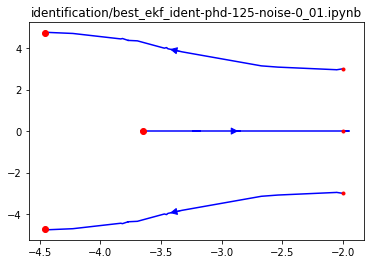

In [9]:
# another approach to plot
real_part = np.squeeze(real_vector(poles))
imag_part = np.squeeze(imag_vector(poles))
    
# Display a window with a plot of real, imag
line = plt.plot(real_part, imag_part, 'b-')
#plt.plot(real_part, imag_part, 'gx')
plt.plot(real_part[-1], imag_part[-1], 'ro')
plt.plot(real_part[0], imag_part[0], 'r.')

try:
    add_arrow(line[0], -3)
    add_arrow(line[1], -3)
    add_arrow(line[2], -3)
except:
    pass
##zeros
#real_part = np.squeeze(real_vector(zeros))
#imag_part = np.squeeze(imag_vector(zeros))
    
# Display a window with a plot of real, imag
#plt.plot(real_part, imag_part, 'g-')
#plt.plot(real_part, imag_part, 'g')
#plt.plot(real_part[-1], imag_part[-1], 'rx')
#plt.plot(real_part[0], imag_part[0], 'bx')

#plt.xlim(-30, 1)
#plt.ylim(-25, 25)
plt.title("identification/best_ekf_ident-phd-125-noise-0_1.ipynb")
plt.show()

In [10]:
#plt.rcParams['figure.figsize'] = [15, 7]
#import mpld3
#mpld3.enable_notebook()

def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

def every_nth(arr, n, T=1):
    return [T*np.array(range(0, len(arr))[::n]), arr[::n]]


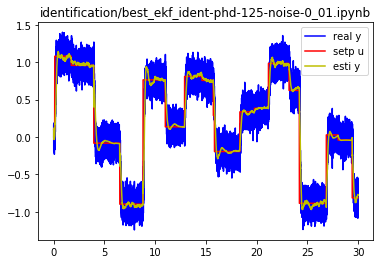

Done steps 19


In [11]:
tt = np.arange(T, T_max, T)

#ax1 = plt.subplot(4, 1, 1)

#ax1.plot(t_ye, nor0, label="trace")
#ax1.plot(t_ye, nor1, label="frobenius")
#ax1.plot(t_ye, nor2, label="inf norm")
#ax1.plot(t_ye, nor3, label="1 norm")
#ax1.plot(t_ye, nor4, label="2 norm")

#ax1.legend()
#  H-inf Norm in mov-window
#  Entropy in mov-window
#  Highpass
#plt.show()

#ax2 = plt.subplot(4, 1, 2, sharex=ax1)

#df1 = pd.DataFrame(y_e, index=t_ye)
#df2 = pd.DataFrame(y, index=tt).fillna(np.inf)
#print df2
#df3 = pd.concat([df1, df2], axis=1).interpolate()

#df_diff = df3.diff(axis=1).iloc[:,1]
#df_diff.plot()

#df_diff.abs().cumsum().plot()
#ax2 = plt.subplot(4, 1, 3, sharex=ax1)
#df_diff.abs().rolling(window=1000, center=True, win_type="bartlett").sum().plot()
#plt.show()

#ax3 = plt.subplot(4, 1, 4, sharex=ax1)

plt.plot(tt, y, 'b', label="real y")
plt.plot(tt, u, 'r', label="setp u")
plt.plot(t_ye, y_e, 'y-', label="esti y")
plt.title("identification/best_ekf_ident-phd-125-noise-0_1.ipynb")
plt.legend()
plt.show()

print "Done steps", step_cnt

In [12]:
print nor0[-1]
print nor1[-1]

46.66328296843214
23.63445598087093


In [13]:
A_k = iekf.AA(*iekf.z_k.ravel())
B_k = iekf.BB(*iekf.z_k.ravel())
C_k = iekf.C0
D_k = iekf.DD(*iekf.z_k.ravel())

ss = pc.ss(A_k, B_k, C_k, D_k)

#print poles[-1]
print ss

A = [[-4.41369501  4.8308102   0.        ]
 [-4.8308102  -4.41369501  0.        ]
 [ 0.          0.         -3.66220833]]

B = [[3.79744722]
 [2.48897889]
 [2.08809828]]

C = [[1. 1. 1.]]

D = [[-0.11359307]]



In [14]:
print pc.dcgain(ss3)
print ss3.pole()
print ss3.zero()
print "----"
print pc.dcgain(ss)
print ss.pole()
print ss.zero()

[[1.0041837]]
[-111.24285968+106.12952188j -111.24285968-106.12952188j
 -140.47828097  +0.        j  -54.39316289  +0.        j
  -20.34039021  +0.        j]
[-1.95450403e+15  +0.       j  1.11242860e+02+106.1295219j
  1.11242860e+02-106.1295219j  1.40478281e+02  +0.       j]
----
[[0.95697136]]
[-4.41369501+4.8308102j -4.41369501-4.8308102j -3.66220833+0.       j]
[68.499939 +0.        j -3.6328161+2.46732427j -3.6328161-2.46732427j]


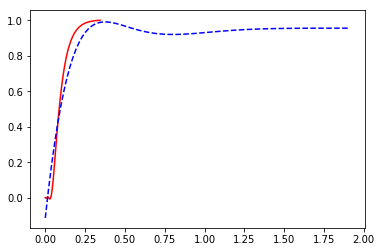

In [15]:
yout3, T3 = pc.step_response(ss3)
plt.plot(yout3, T3, 'r')
#plt.show()

yout4, T4 = pc.step_response(ss)
plt.plot(yout4, T4, 'b--')



plt.show()